## Recreating PINN architecture for the continous burger equation
Structure:
- 9 layers
- Hidden layers with 20 neurons
- input layer with 2 neurons ($x$ and $t$)
- output layers with 1 neuron ($u(x,t)$)

In [15]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import math

np.random.seed(1234)
from scipy.special import gamma

In [16]:
import torch.nn as nn
from torch.autograd import Variable
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [17]:
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        self.alpha = 0.00001
    
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
        
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        # self.alpha += 0.00001
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
            print(f"alpha: {self.alpha}")
        return loss
    
    def train(self):
        self.dnn.train()
        
        # self.alpha -= 0.00001
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [18]:
class CaputoPINN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, alpha = 0.99, delta_t = 0.01):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        self.delta_t = delta_t
        self.alpha = alpha

    
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def k(self, n, j):
        k_n_j = (self.delta_t**(-self.alpha)/gamma(2-self.alpha)) * (((n-j+1) ** self.alpha) - ((n-j) ** (1-self.alpha)))
        return k_n_j
    
    def caputo(self, X , T):
        n = torch.ceil(T[:,0] / self.delta_t).long()
        time_grid = [torch.arange(start=0.0, end=n_i, step=self.delta_t) for n_i in n]
        caputo_results = np.zeros((X.shape[0], X.shape[1]))
        i = 0
        for series, x, n_i in zip(time_grid, X, n):
            U = []
            for tao in series:
                if tao == 0:
                    continue
                x_i, tao_i = x.unsqueeze(0), tao.unsqueeze(0).unsqueeze(0)
                out = self.net_u(x_i, tao_i)
                U.append(out)

            caputo = 0
            for j in range(0,n_i):
                theta = self.k(n_i.item(),j) - self.k(n_i.item(), j+1)
                caputo += theta * U[j]
            caputo_results[i] = caputo.item()
            i += 1
        results = torch.tensor(caputo_results, requires_grad=True).float().to(device)
        return results

        
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        # u_t = torch.autograd.grad(
        #     u, t, 
        #     grad_outputs=torch.ones_like(u),
        #     retain_graph=True,
        #     create_graph=True
        # )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = self.caputo(x,t) + u * u_x - self.nu * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        # self.alpha += 0.00001
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
            print(f"alpha: {self.alpha}")
        return loss
    
    def train(self):
        self.dnn.train()
        
        # self.alpha -= 0.00001
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [19]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# x,t and usol are the main things we need
data = scipy.io.loadmat("data/burgers_shock.mat")

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    
    
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

In [5]:
temp_x_f_train = X_f_train[:10]

In [20]:
test_pinn = PhysicsInformedNN(X_u_train[:10], u_train[:10], X_f_train[:10], layers, lb, ub, nu)
test_caputo_pinn = CaputoPINN(X_u_train[:10], u_train[:10], X_f_train[:10], layers, lb, ub, nu, alpha=0.99, delta_t=0.01)

In [25]:
%%time

test_pinn.train()

CPU times: user 264 ms, sys: 3.9 ms, total: 268 ms
Wall time: 35.2 ms


In [26]:
%%time

test_caputo_pinn.train()

CPU times: user 42.1 s, sys: 149 ms, total: 42.3 s
Wall time: 42.2 s


In [28]:
x_f = torch.tensor(temp_x_f_train[:, 0:1], requires_grad=True).float().to(device)
t_f = torch.tensor(temp_x_f_train[:, 1:2], requires_grad=True).float().to(device)
delta_t = 0.01
alpha = 0.99

n = torch.ceil(t_f[:,0] / delta_t).long()
time_grid = [torch.arange(start=0.0, end=n_i, step=delta_t) for n_i in n]
print(time_grid)

[tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 6.2970e+01, 6.2980e+01,
        6.2990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 4.4970e+01, 4.4980e+01,
        4.4990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 8.9970e+01, 8.9980e+01,
        8.9990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 6.8970e+01, 6.8980e+01,
        6.8990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 5.7970e+01, 5.7980e+01,
        5.7990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 2.0970e+01, 2.0980e+01,
        2.0990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 9.0970e+01, 9.0980e+01,
        9.0990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 3.3970e+01, 3.3980e+01,
        3.3990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 2.3970e+01, 2.3980e+01,
        2.3990e+01]), tensor([0.0000e+00, 1.0000e-02, 2.0000e-02,  ..., 2.8970e+01, 2.8980e+01,
        2.8990e+01])]


In [8]:
for series, x in zip(time_grid, x_f):
    for tao in series:
        if tao == 0:
            continue
        # print(tao.unsqueeze(0).shape, x.shape)
        # k = torch.cat([x.unsqueeze(0), tao.unsqueeze(0).unsqueeze(0)], dim=1)
        x, tao = x.unsqueeze(0), tao.unsqueeze(0).unsqueeze(0)
        print(x.shape, tao.shape)
        break
    break

torch.Size([1, 1]) torch.Size([1, 1])


In [29]:
def k(n, j):
    k_n_j = (delta_t**(-alpha)/gamma(2-alpha)) * (((n-j+1) ** alpha) - ((n-j) ** (1-alpha)))
    return k_n_j

In [54]:
i = 0
caputo_results = np.zeros((x_f.shape[0],x_f.shape[1]))
for series, x, n_i in zip(time_grid, x_f, n):
    U = []
    for tao in series:
        if tao == 0:
            continue
        x_i, tao_i = x.unsqueeze(0), tao.unsqueeze(0).unsqueeze(0)
        out = test_model.net_u(x_i, tao_i)
        U.append(out)
    caputo = 0
    for j in range(0,n_i):
        theta = k(n_i.item(),j) - k(n_i.item(), j+1)
        caputo += theta * U[j]
    caputo_results[i] = caputo.item()
    print(f"Iteration: {i+1}")
    i += 1

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


# Running notes on model

- Looks like the caputo makes it converge to a trivial solution
    - 

In [27]:
u_pred, f_pred = test_caputo_pinn.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

AttributeError: 'int' object has no attribute 'item'

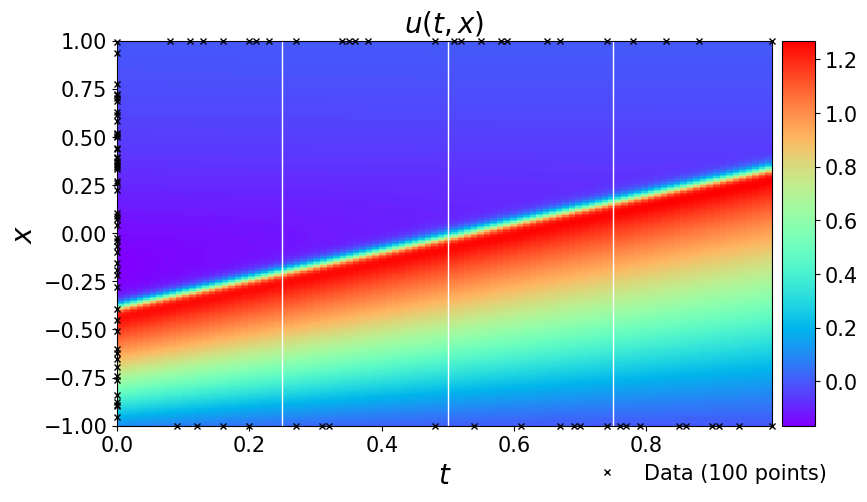

In [23]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

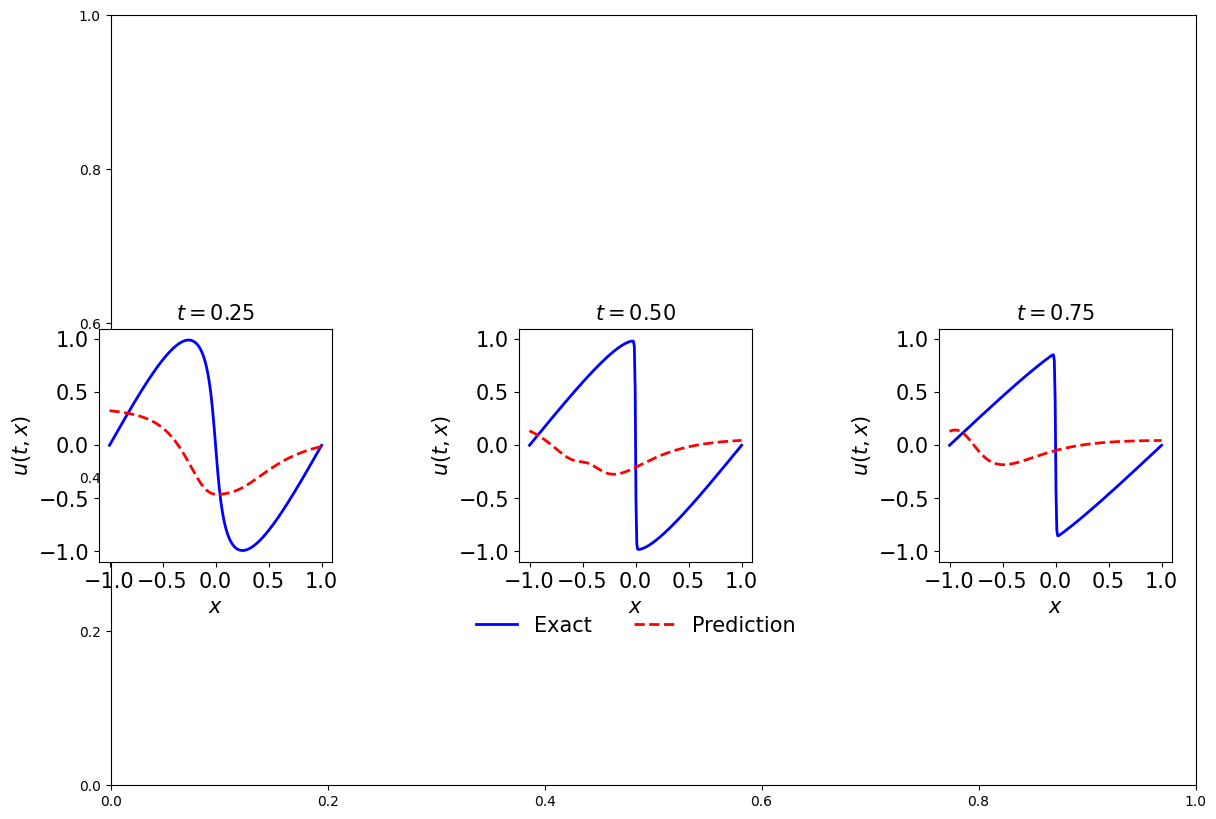

In [45]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()